## Environment settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import Resnet    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
%matplotlib notebook

## Solving PDEs

Two-dimensional PDEs can be solved by the legacy `neurodiffeq.pde.solve2D` or the more flexible `neurodiffeq.solvers.Solver2D`.

Aain, just for the sake of notation in the following examples, here we see differentiation as an operation, then an PDE of $u(x, y)$ can be rewritten as: 

$$F(u, x, y) = 0.$$

### PDE Example 1: Laplace's Equation

Here we solve 2-D Laplace equation on a Cartesian boundary with Dirichlet boundary condition:

$$
F(u, x, y) = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0
$$

for $(x, y) \in [0, 1] \times [0, 1]$

s.t.

$$
u(x, y)\bigg|_{x=0} = \sin(\pi y) \\
u(x, y)\bigg|_{x=1} = 0 \\
u(x, y)\bigg|_{y=0} = 0 \\
u(x, y)\bigg|_{y=1} = 0
$$

The analytical solution is

$$
u(x, y) = \frac{\sin(\pi y) \sinh(\pi(1-x))}{\sinh(\pi)}
$$

Here we have a Dirichlet boundary condition on both 4 edges of the orthogonal box. We will be using `DirichletBVP2D` for this boundary condition. The arguments `x_min_val`, `x_max_val`, `y_min_val` and `y_max_val` correspond to $u(x, y)\bigg|_{x=0}$, $u(x, y)\bigg|_{x=1}$, $u(x, y)\bigg|_{y=0}$ and $u(x, y)\bigg|_{y=1}$. Note that they should all be functions of $x$ or $y$. These functions are expected to take in a `torch.tensor` and return a `torch.tensor`, so if the function involves some elementary functions like $\sin$, we should use `torch.sin` instead of `numpy.sin`.

Like in the ODE case, we have two ways to solve 2-D PDEs.

1. The `neurodiffeq.pde.solve2D` function is almost the same as `solve` and `solve_system` in the `neurodiffeq.ode` module. Again, **this way is deprecated and won't be covered here**.
2. The `neurodiffeq.solvers.Solver2D` class is almost the same as `neurodiffeq.solvers.Solver1D`.

The difference is that we indicate the domain of our problem with `xy_min` and `xy_max`, they are tuples representing the 'lower left' point and 'upper right' point of our domain. 

Also, we need to use `neurodiffeq.generators.Generator2D` and `neurodiffeq.monitors.Monitor2D`.

In [27]:
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
import torch

<IPython.core.display.Javascript object>


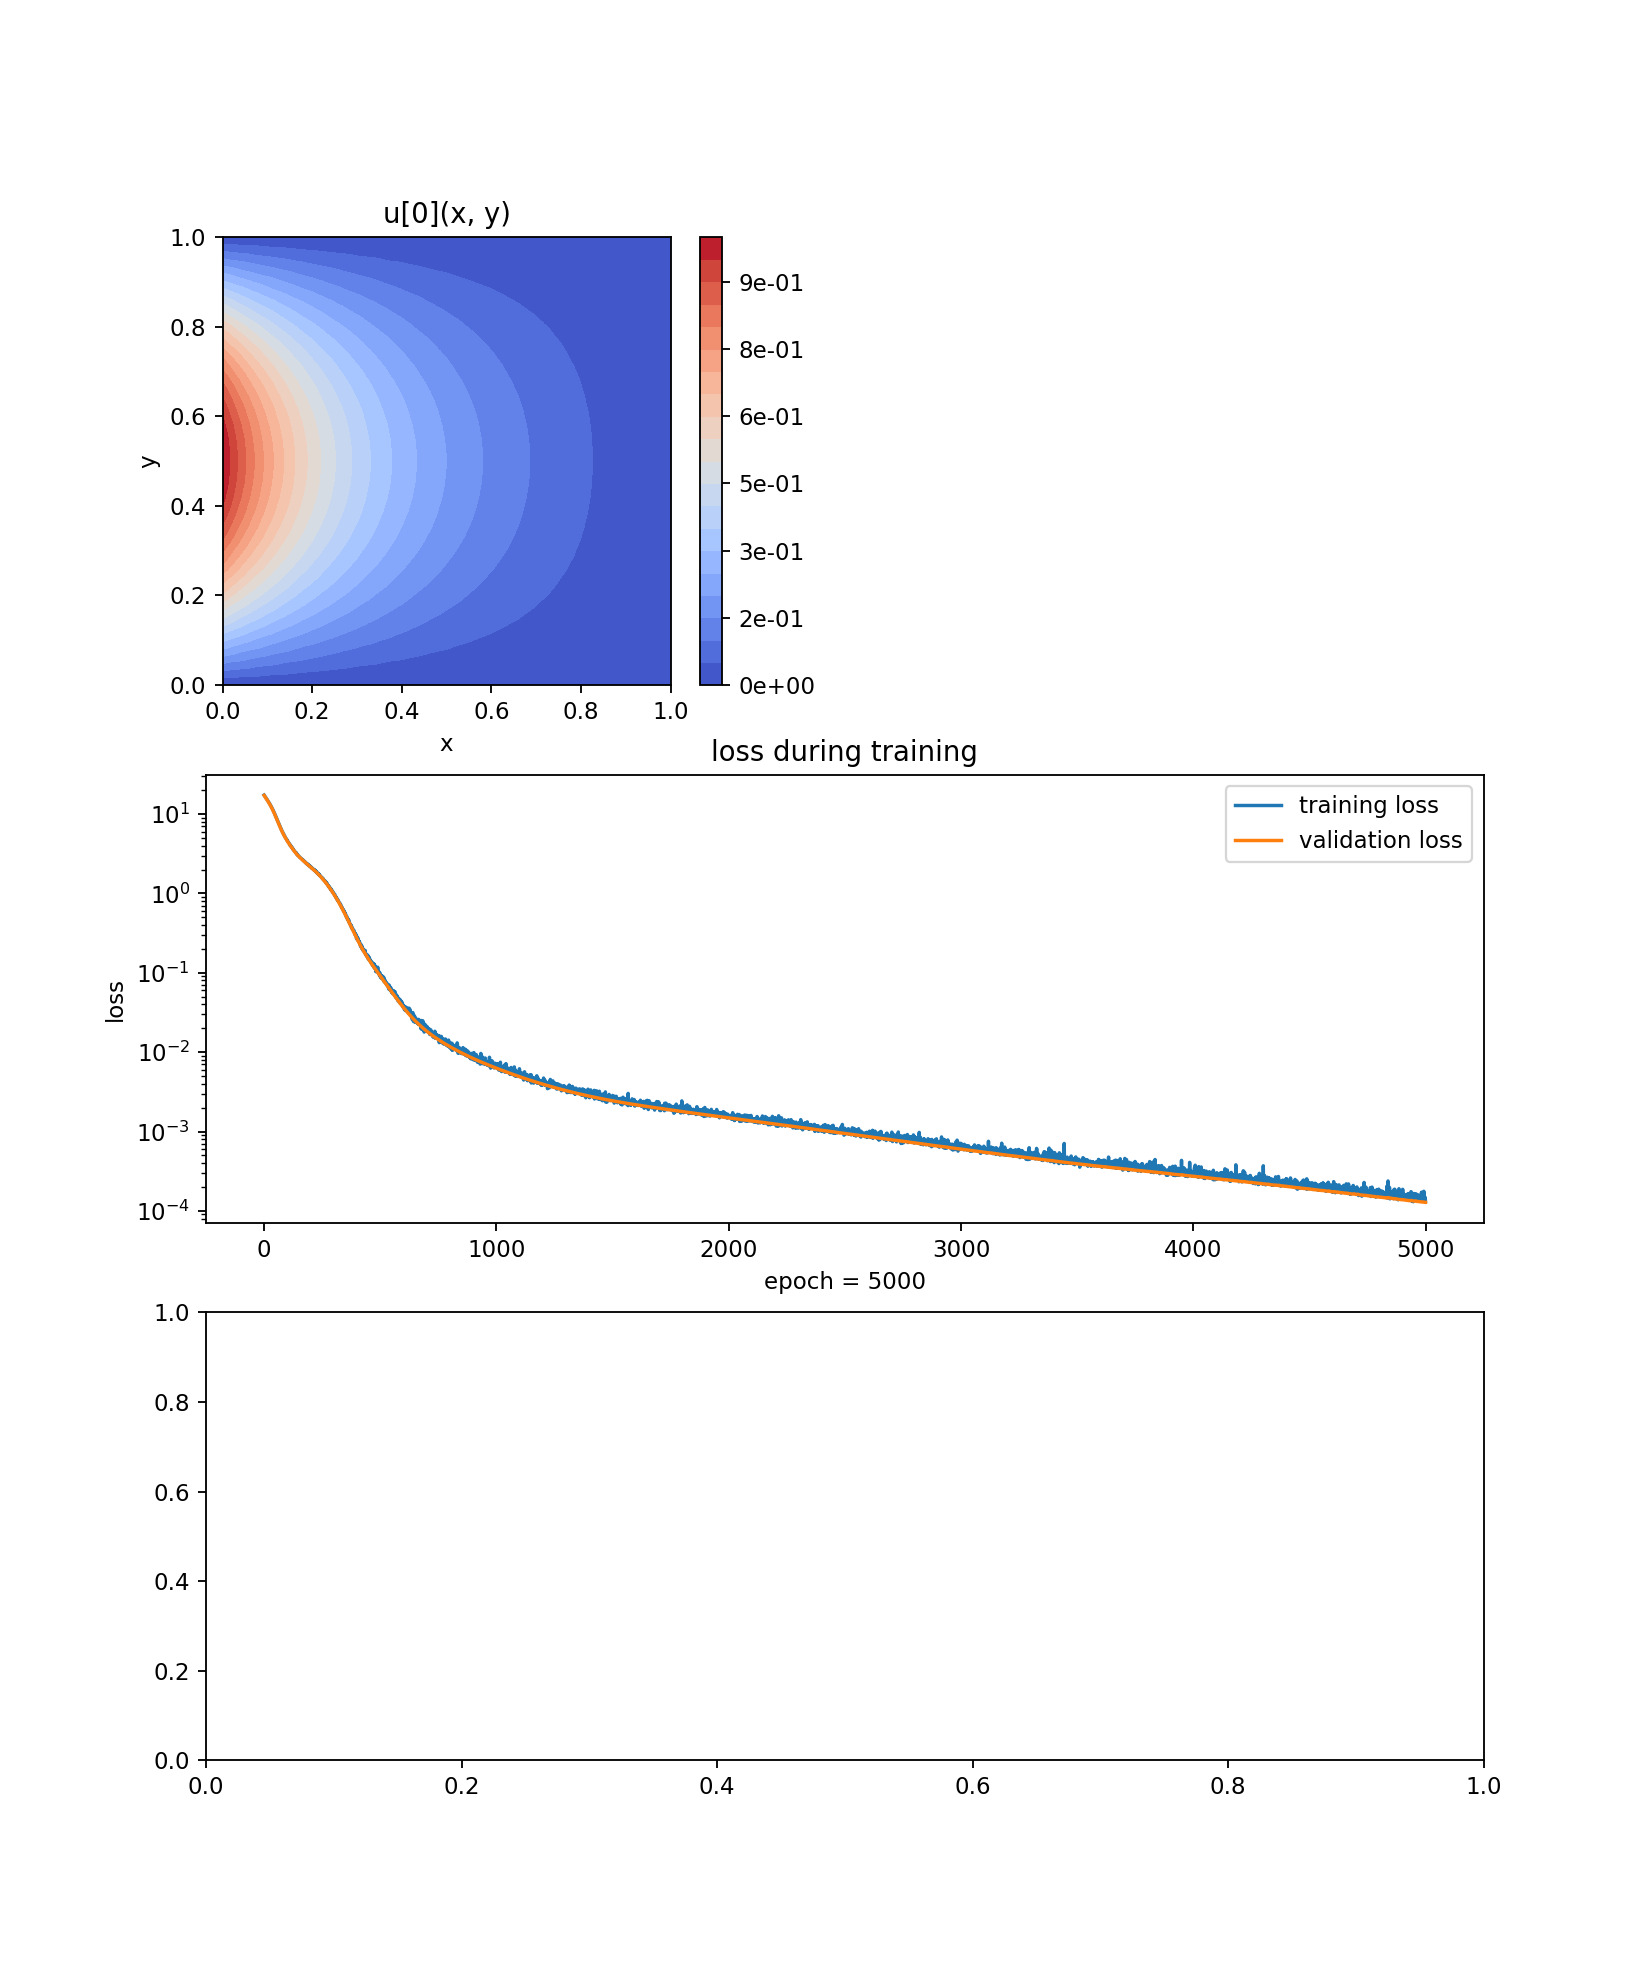

In [28]:
# Define the PDE system
# There's only one (Laplace) equation in the system, so the function maps (u, x, y) to a single entry
laplace = lambda u, x, y: [diff(u, x, order=2) + diff(u, y, order=2)]

# Define the boundary conditions
# There's only one function to be solved for, so we only have a single condition
conditions = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: torch.sin(np.pi*y), 
        x_max=1, x_max_val=lambda y: 0, 
        y_min=0, y_min_val=lambda x: 0, 
        y_max=1, y_max_val=lambda x: 0,
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=(32,32))
]

# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_laplace = solver.get_solution()

Here we create a function to help us visualize the shape of the solution and the residual.

In [12]:
from mpl_toolkits.mplot3d  import Axes3D
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    fig.suptitle(title)
    ax.set_proj_type('ortho')
    plt.show()

In [13]:
xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
sol_net = solution_neural_net_laplace(xx, yy, to_numpy=True)
plt_surf(xx, yy, sol_net, title='$u(x, y)$ as solved by neural network')

<IPython.core.display.Javascript object>

In [14]:
solution_analytical_laplace = lambda x, y: np.sin(np.pi*y) * np.sinh(np.pi*(1-x))/np.sinh(np.pi)
sol_ana = solution_analytical_laplace(xx, yy)
plt_surf(xx, yy, sol_net-sol_ana, z_label='residual', title='residual of the neural network solution')

<IPython.core.display.Javascript object>

### PDE Example 2: 1-D Heat Equation

Here we solve 1-D heat equation:

$$
\frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2} = 0
$$

with an initial condition and 2 Neumann boundary on each end:

$$
u(x, t)\bigg|_{t=0} = \sin(\pi x) \\
\frac{\partial u(x, t)}{\partial x}\bigg|_{x=0} = \pi\exp(-k\pi^2 t) \\
\frac{\partial u(x, t)}{\partial x}\bigg|_{x=1} = -\pi\exp(-k\pi^2 t)
$$

The analytical solution is:

$$
u(x, t) = \sin(\pi \frac{x}{L}) \exp(\frac{-k \pi^2 t}{L^2})
$$

Since we are still solving in a 2-D space ($x$ and $t$), we will still be using `solve2D`. We use a `IBVP1D` condition to enforce our initial and boundary condition. The arguments `t_min_val`, `x_min_prime`, and `x_max_prime` correspond to $u(x, t)\bigg|_{t=0}$, $\displaystyle\frac{\partial u(x, t)}{\partial x}\bigg|_{x=0}$ and $\displaystyle\frac{\partial u(x, t)}{\partial x}\bigg|_{x=1}$.

In [15]:
from neurodiffeq.conditions import IBVP1D 
from neurodiffeq.pde import make_animation

<IPython.core.display.Javascript object>


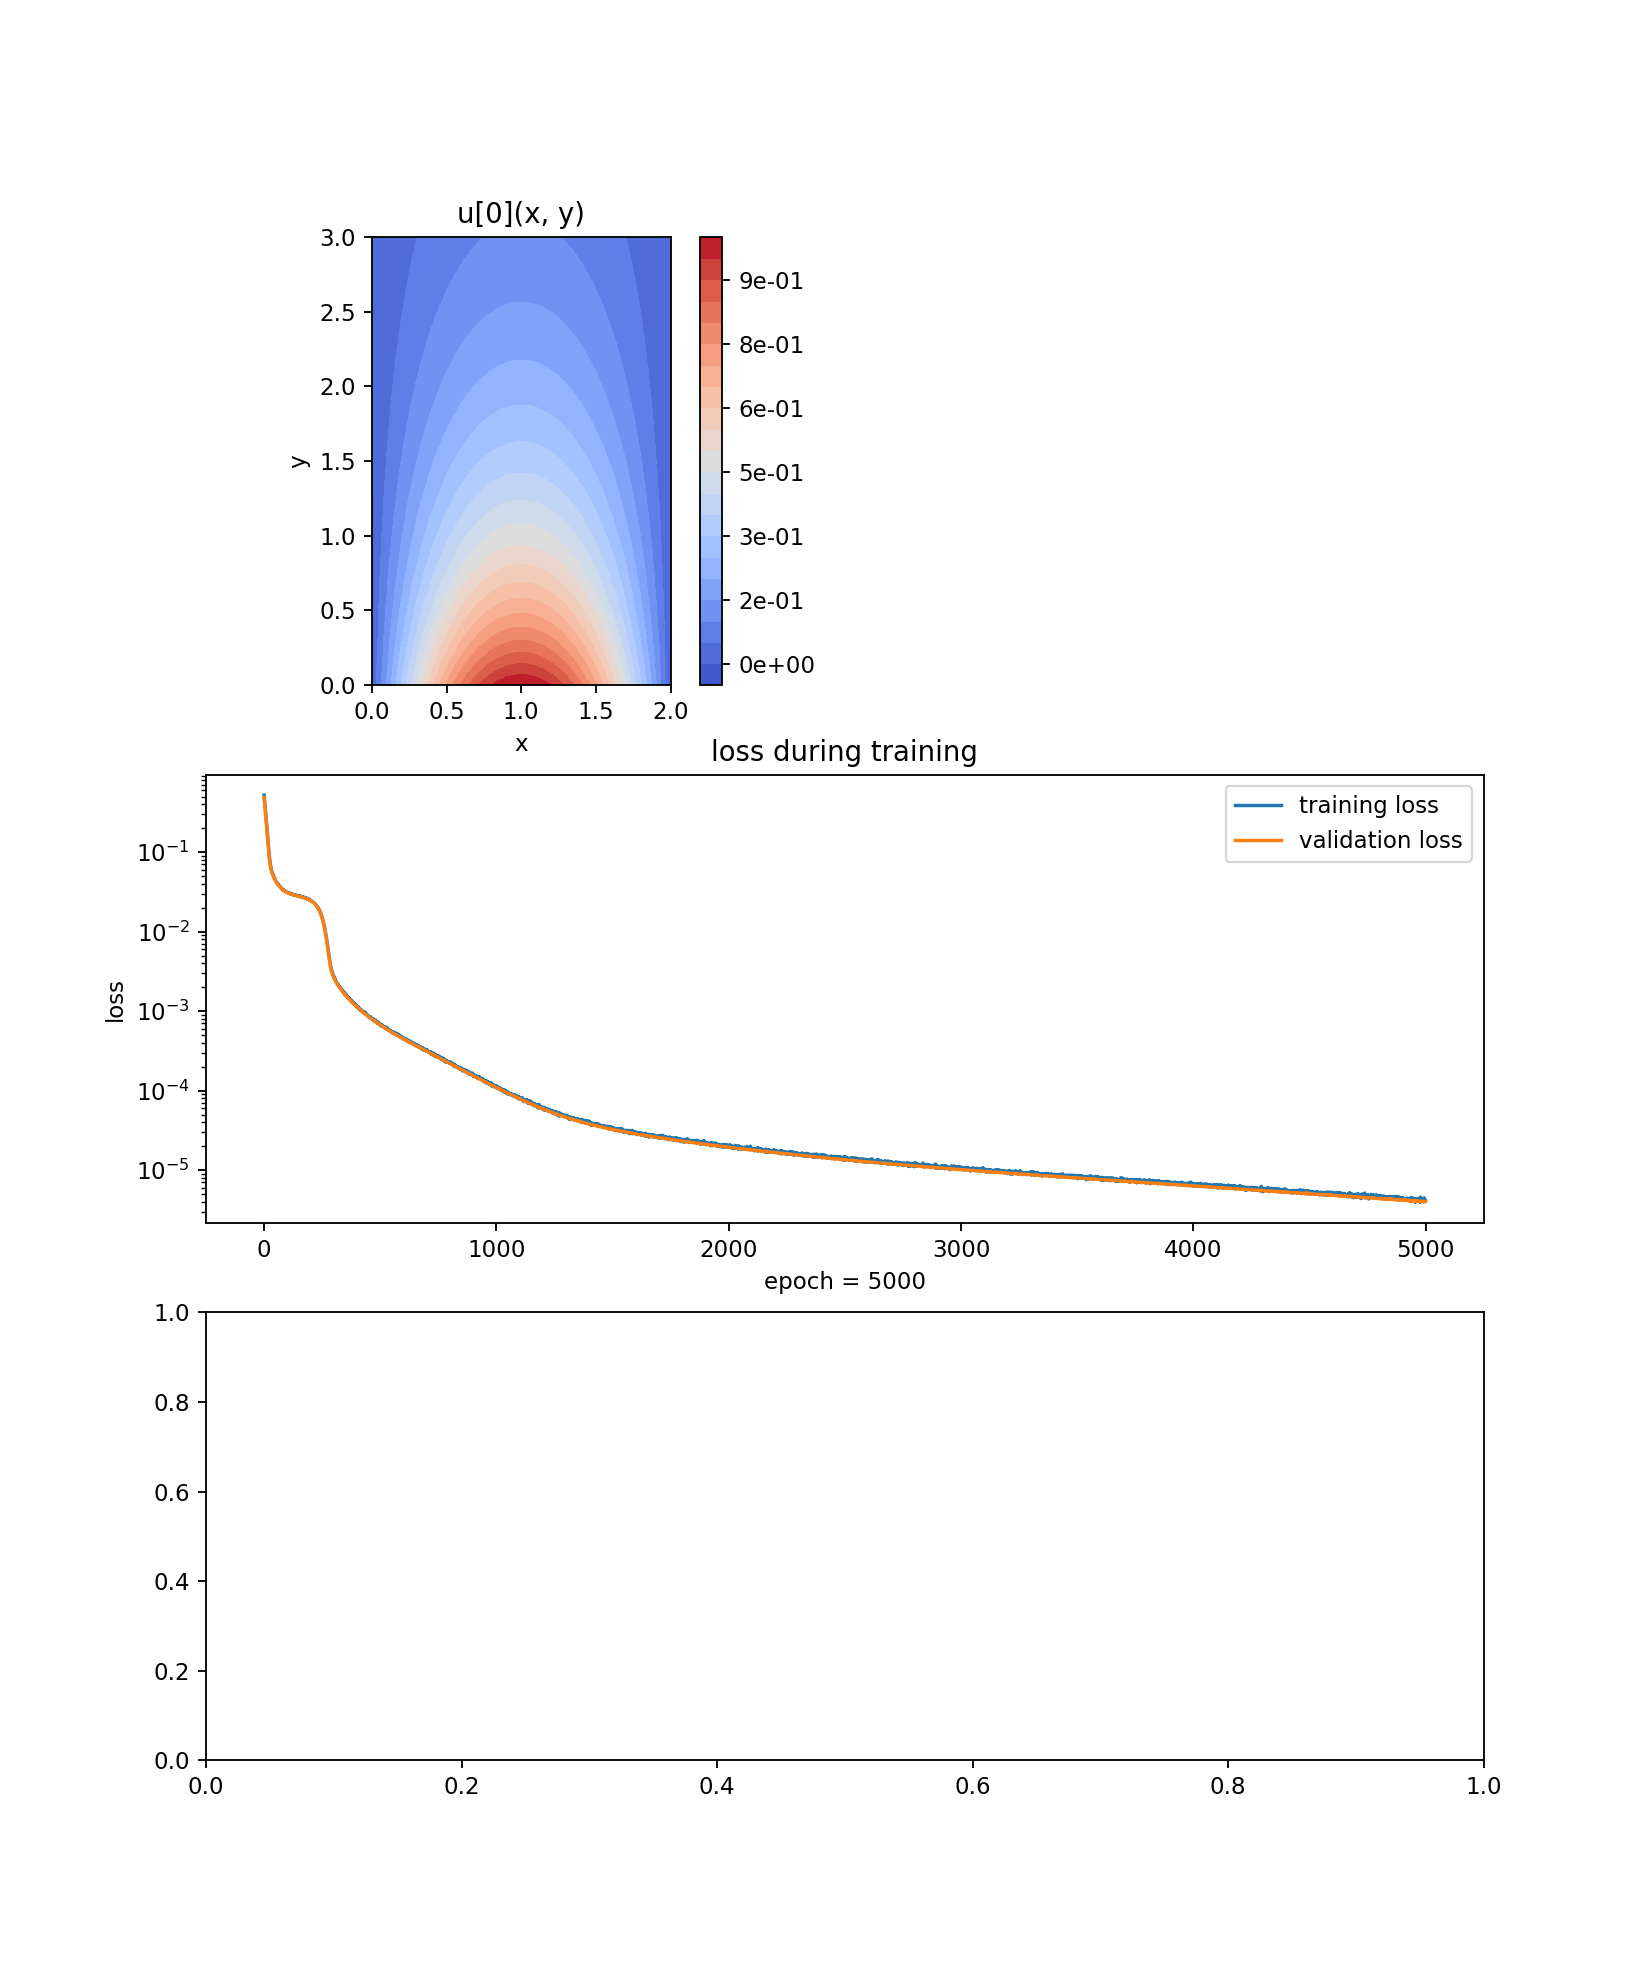

In [26]:
k, L, T = 0.3, 2, 3
# Define the PDE system
# There's only one (heat) equation in the system, so the function maps (u, x, y) to a single entry
heat = lambda u, x, t: [
    diff(u, t) - k * diff(u, x, order=2)
]

# Define the initial and boundary conditions
# There's only one function to be solved for, so we only have a single condition object
conditions = [
    IBVP1D(
        t_min=0, t_min_val=lambda x: torch.sin(np.pi * x / L),
        x_min=0, x_min_prime=lambda t:  np.pi/L * torch.exp(-k*np.pi**2*t/L**2),
        x_max=L, x_max_prime=lambda t: -np.pi/L * torch.exp(-k*np.pi**2*t/L**2)
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, hidden_units=(32, 32),actv=SinActv)
]


# Define the monitor callback
monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(L, T))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver = Solver2D(
    pde_system=heat,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(L, T),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (L, T), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (L, T), method='equally-spaced'),
)

# Fit the neural network
solver.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_heat = solver.get_solution()

## Animation on loss and trial solution

Now, we wish empirically compare the computational performance of PiNNs with different configurations, trying to optimize the training cost by adjusting its hyperparameters (layers, neurons, activation functions, training points generators, and epochs). 

We can use `make_animation` to animate the solution. Here we also check the residual of our solution.

<IPython.core.display.Javascript object>


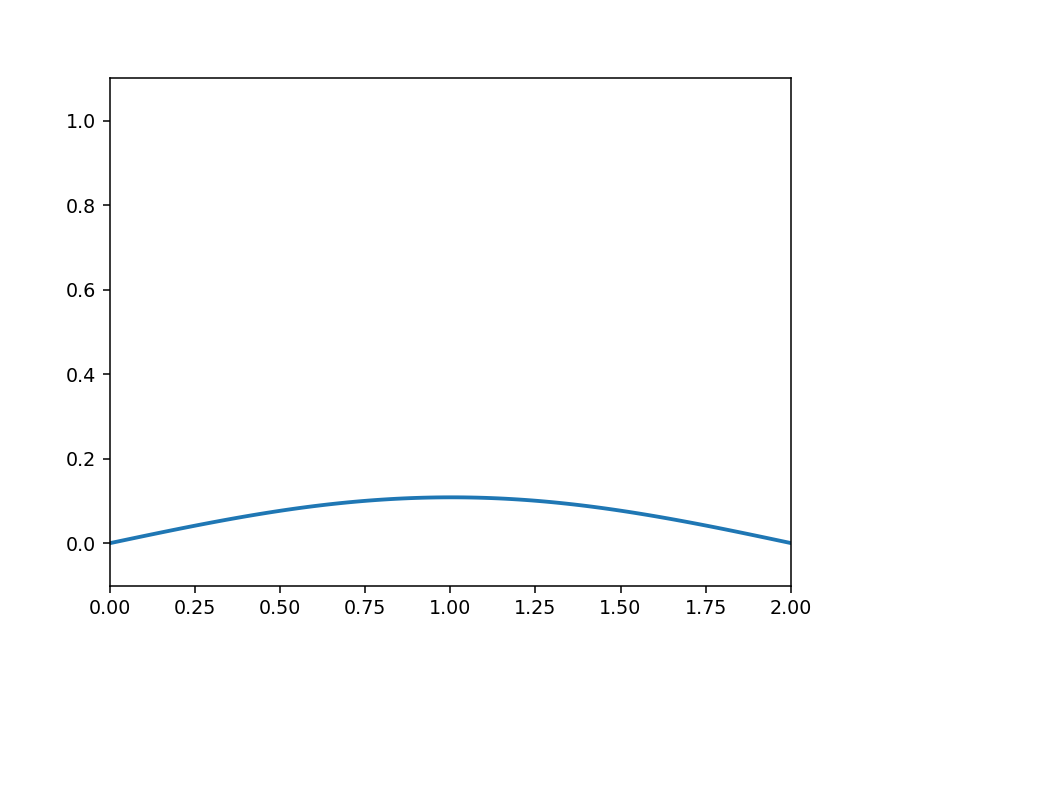

In [24]:
xs = np.linspace(0, L, 101)
ts = np.linspace(0, T, 101) 
xx, tt = np.meshgrid(xs, ts)
make_animation(solution_neural_net_heat, xs, ts)

<IPython.core.display.Javascript object>


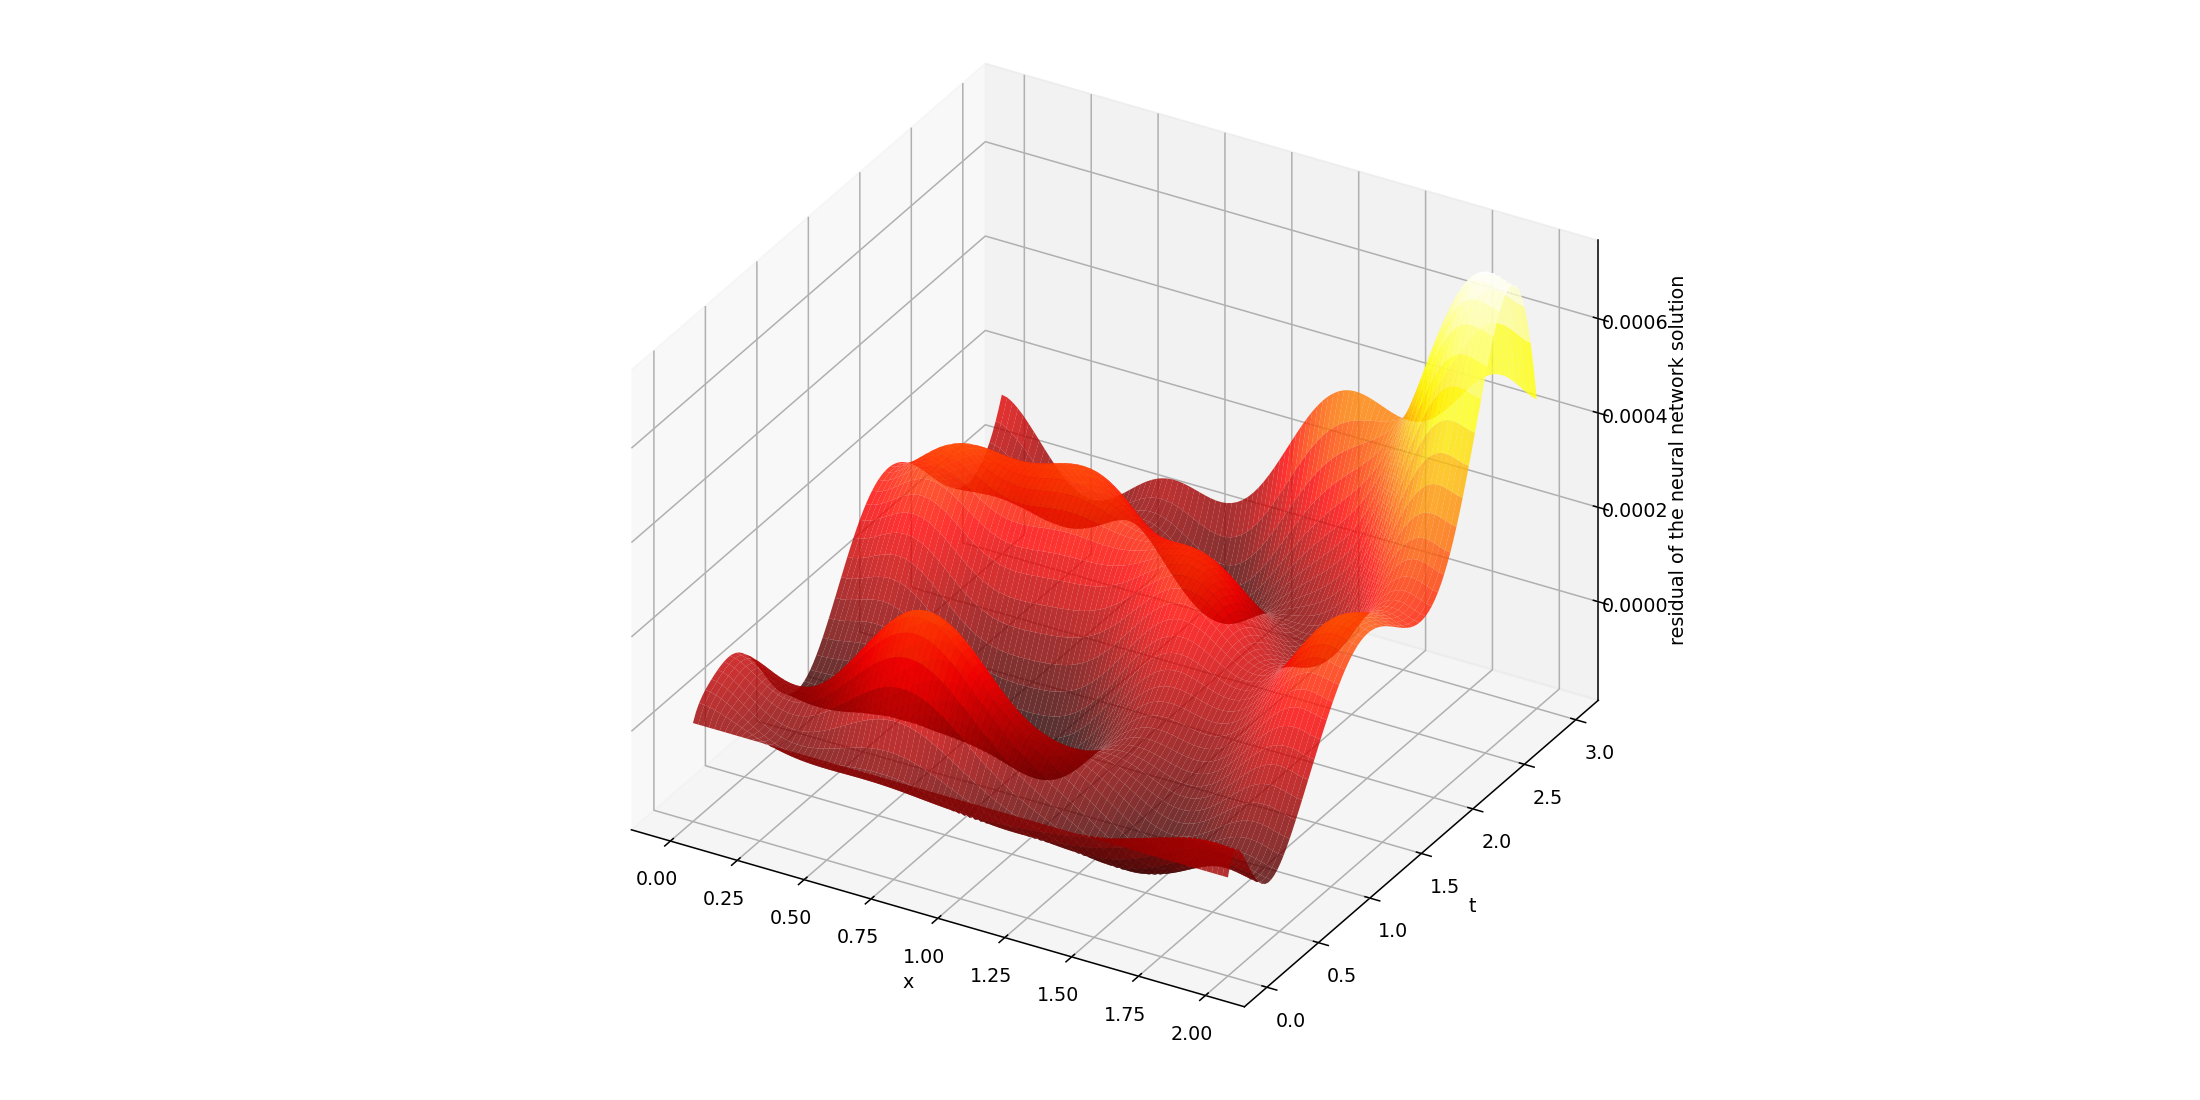

In [23]:
solution_analytical_heat = lambda x, t: np.sin(np.pi*x/L) * np.exp(-k * np.pi**2 * t / L**2)
sol_ana = solution_analytical_heat(xx, tt)
sol_net = solution_neural_net_heat(xx, tt, to_numpy=True)
plt_surf(xx, tt, sol_net-sol_ana, y_label='t', z_label='residual of the neural network solution')

## Customized Boundary or Initial Conditions
To satisfy our needs on BCs of an onmipresent wave equation, we now customize our BC/IC module to create a suitable class.

In [19]:
from neurodiffeq.conditions import BaseCondition

In [20]:
class BC2IV2(BaseCondition):
    r"""An initial & boundary condition on a 1-D range where :math:`x\in[x_0, x_1]` and time starts at :math:`t_0`.
    The conditions should have the following parts:

    - :math:`u(x,t_0)=u_0(x)`,
    - :math:`u(x_0,t)=g(t)` or :math:`u'_x(x_0,t)=p(t)`,
    - :math:`u(x_1,t)=h(t)` or :math:`u'_x(x_1,t)=q(t)`,

    where :math:`\displaystyle u'_x=\frac{\partial u}{\partial x}`.

    :param x_min: The lower bound of x, the :math:`x_0`.
    :type x_min: float
    :param x_max: The upper bound of x, the :math:`x_1`.
    :type x_max: float
    :param t_min: The initial time, the :math:`t_0`.
    :type t_min: float
    :param t_min_val: The initial condition, the :math:`u_0(x)`.
    :type t_min_val: callable
    :param t_min_prime: The initial condition, the :math:`u_0(x)` w.r.t. `t`
    :type t_min_prime: callable, optional
    :param x_min_val: The Dirichlet boundary condition when :math:`x = x_0`, the :math:`u(x_0, t)`, defaults to None.
    :type x_min_val: callable, optional
    :param x_min_prime: The Neumann boundary condition when :math:`x = x_0`, the :math:`u'_x(x_0, t)`, defaults to None.
    :type x_min_prime: callable, optional
    :param x_max_val: The Dirichlet boundary condition when :math:`x = x_1`, the :math:`u(x_1, t)`, defaults to None.
    :type x_max_val: callable, optional
    :param x_max_prime: The Neumann boundary condition when :math:`x = x_1`, the :math:`u'_x(x_1, t)`, defaults to None.
    :type x_max_prime: callable, optional
    :raises NotImplementedError: When unimplemented boundary conditions are configured.

    .. note::
        This condition cannot be passed to ``neurodiffeq.conditions.EnsembleCondition`` unless both boundaries uses
        Dirichlet conditions (by specifying only ``x_min_val`` and ``x_max_val``) and ``force`` is set to True in
        EnsembleCondition's constructor.
    """

    def __init__(
            self, x_min, x_max, t_min, t_min_val,t_min_prime,
            x_min_val=None, x_min_prime=None,
            x_max_val=None, x_max_prime=None,
    ):
        super().__init__()
        n_conditions = sum(c is not None for c in [x_min_val, x_min_prime, x_max_val, x_max_prime])
        if n_conditions != 2 or (x_min_val and x_min_prime) or (x_max_val and x_max_prime):
            raise NotImplementedError('Sorry, this boundary condition is not implemented.')
        self.x_min, self.x_min_val, self.x_min_prime = x_min, x_min_val, x_min_prime
        self.x_max, self.x_max_val, self.x_max_prime = x_max, x_max_val, x_max_prime
        self.t_min, self.t_min_val, self.t_min_prime = t_min, t_min_val, t_min_prime

    def enforce(self, net, x, t):
        r"""Enforces this condition on a network with inputs `x` and `t`

        :param net: The network whose output is to be re-parameterized.
        :type net: `torch.nn.Module`
        :param x: The :math:`x`-coordinates of the samples; i.e., the spatial coordinates.
        :type x: `torch.Tensor`
        :param t: The :math:`t`-coordinates of the samples; i.e., the temporal coordinates.
        :type t: `torch.Tensor`
        :return: The re-parameterized output, where the condition is automatically satisfied.
        :rtype: `torch.Tensor`

        .. note::
            This method overrides the default method of ``neurodiffeq.conditions.BaseCondition`` .
            In general, you should avoid overriding ``enforce`` when implementing custom boundary conditions.
        """

        def ANN(x, t):
            out = net(torch.cat([x, t], dim=1))
            if self.ith_unit is not None:
                out = out[:, self.ith_unit].view(-1, 1)
            return out

        uxt = ANN(x, t)
        if self.x_min_val and self.x_max_val and self.t_min_prime:
            t0 = self.t_min * torch.ones_like(t, requires_grad=True)
            x0 = self.x_min * torch.ones_like(x, requires_grad=True)
            x1 = self.x_max * torch.ones_like(x, requires_grad=True)
            uxt0 = ANN(x, t0)
            return self.parameterize(uxt, x, t, uxt0, t0 ,x0, x1)
        elif self.x_min_val and self.x_max_prime and self.t_min_prime:
            x1 = self.x_max * torch.ones_like(x, requires_grad=True)
            t0 = self.t_min * torch.ones_like(t, requires_grad=True)
            ux1t = ANN(x1, t)
            uxt0 = ANN(x, t0)
            return self.parameterize(uxt, x, t, ux1t, x1, uxt0, t0)
        elif self.x_min_prime and self.x_max_val and self.t_min_prime:
            x0 = self.x_min * torch.ones_like(x, requires_grad=True)
            t0 = self.t_min * torch.ones_like(t, requires_grad=True)
            ux0t = ANN(x0, t)
            uxt0 = ANN(x, t0)
            return self.parameterize(uxt, x, t, ux0t, x0, uxt0, t0)
        elif self.x_min_prime and self.x_max_prime and self.t_min_prime:
            x0 = self.x_min * torch.ones_like(x, requires_grad=True)
            x1 = self.x_max * torch.ones_like(x, requires_grad=True)
            t0 = self.t_min * torch.ones_like(t, requires_grad=True)
            ux0t = ANN(x0, t)
            ux1t = ANN(x1, t)
            uxt0 = ANN(x, t0)
            return self.parameterize(uxt, x, t, ux0t, x0, ux1t, x1, uxt0, t0)
        else:
            raise NotImplementedError('Sorry, this boundary condition is not implemented.')

    def parameterize(self, u, x, t, *additional_tensors):
        r"""Re-parameterizes outputs such that the initial and boundary conditions are satisfied.

        The Initial conditions are always :math:`u(x,t_0)=u_0(x)` and `u'_t(x, t_0)=u_0_prime(x)`. There are four boundary conditions that are
        currently implemented:

        - For Dirichlet-Dirichlet boundary condition :math:`u(x_0,t)=g(t)` and :math:`u(x_1,t)=h(t)`:

          The re-parameterization is
          :math:`\displaystyle u(x,t)=A(x,t)+\tilde{x}\big(1-\tilde{x}\big)\Big(1-e^{-\tilde{t}}\Big)\mathrm{ANN}(x,t)`,
          where :math:`\displaystyle A(x,t)=u_0(x)+
          \tilde{x}\big(h(t)-h(t_0)\big)+\big(1-\tilde{x}\big)\big(g(t)-g(t_0)\big)`.

        - For Dirichlet-Neumann boundary condition :math:`u(x_0,t)=g(t)` and :math:`u'_x(x_1, t)=q(t)`:

          The re-parameterization is
          :math:`\displaystyle u(x,t)=A(x,t)+\tilde{x}\Big(1-e^{-\tilde{t}}\Big)
          \Big(\mathrm{ANN}(x,t)-\big(x_1-x_0\big)\mathrm{ANN}'_x(x_1,t)-\mathrm{ANN}(x_1,t)\Big)`,
          where :math:`\displaystyle A(x,t)=u_0(x)+\big(x-x_0\big)\big(q(t)-q(t_0)\big)+\big(g(t)-g(t_0)\big)`.

        - For Neumann-Dirichlet boundary condition :math:`u'_x(x_0,t)=p(t)` and :math:`u(x_1, t)=h(t)`:

          The re-parameterization is
          :math:`\displaystyle u(x,t)=A(x,t)+\big(1-\tilde{x}\big)\Big(1-e^{-\tilde{t}}\Big)
          \Big(\mathrm{ANN}(x,t)-\big(x_1-x_0\big)\mathrm{ANN}'_x(x_0,t)-\mathrm{ANN}(x_0,t)\Big)`,
          where :math:`\displaystyle A(x,t)=u_0(x)+\big(x_1-x\big)\big(p(t)-p(t_0)\big)+\big(h(t)-h(t_0)\big)`.

        - For Neumann-Neumann boundary condition :math:`u'_x(x_0,t)=p(t)` and :math:`u'_x(x_1, t)=q(t)`

          The re-parameterization is
          :math:`\displaystyle u(x,t)=A(x,t)+\left(1-e^{-\tilde{t}}\right)
          \Big(
          \mathrm{ANN}(x,t)-\big(x-x_0\big)\mathrm{ANN}'_x(x_0,t)
          +\frac{1}{2}\tilde{x}^2\big(x_1-x_0\big)
          \big(\mathrm{ANN}'_x(x_0,t)-\mathrm{ANN}'_x(x_1,t)\big)
          \Big)`,
          where :math:`\displaystyle A(x,t)=u_0(x)
          -\frac{1}{2}\big(1-\tilde{x}\big)^2\big(x_1-x_0\big)\big(p(t)-p(t_0)\big)
          +\frac{1}{2}\tilde{x}^2\big(x_1-x_0\big)\big(q(t)-q(t_0)\big)`.

        Notations:

        - :math:`\displaystyle\tilde{t}=\frac{t-t_0}{t_1-t_0}`,
        - :math:`\displaystyle\tilde{x}=\frac{x-x_0}{x_1-x_0}`,
        - :math:`\displaystyle\mathrm{ANN}` is the neural network,
        - and :math:`\displaystyle\mathrm{ANN}'_x=\frac{\partial ANN}{\partial x}`.

        :param output_tensor: Output of the neural network.
        :type output_tensor: `torch.Tensor`
        :param x: The :math:`x`-coordinates of the samples; i.e., the spatial coordinates.
        :type x: `torch.Tensor`
        :param t: The :math:`t`-coordinates of the samples; i.e., the temporal coordinates.
        :type t: `torch.Tensor`
        :param additional_tensors: additional tensors that will be passed by ``enforce``
        :type additional_tensors: `torch.Tensor`
        :return: The re-parameterized output of the network.
        :rtype: `torch.Tensor`
        """

        t0 = self.t_min * torch.ones_like(t, requires_grad=True)
        x_tilde = (x - self.x_min) / (self.x_max - self.x_min)
        t_tilde = t - self.t_min

        if self.x_min_val and self.x_max_val:
            return self._parameterize_dd(u, x, t, x_tilde, t_tilde, t0, *additional_tensors)
        elif self.x_min_val and self.x_max_prime:
            return self._parameterize_dn(u, x, t, x_tilde, t_tilde, t0, *additional_tensors)
        elif self.x_min_prime and self.x_max_val:
            return self._parameterize_nd(u, x, t, x_tilde, t_tilde, t0, *additional_tensors)
        elif self.x_min_prime and self.x_max_prime:
            return self._parameterize_nn(u, x, t, x_tilde, t_tilde, t0, *additional_tensors)
        else:
            raise NotImplementedError('Sorry, this boundary condition is not implemented.')

    # When we have Dirichlet boundary conditions on both ends of the domain:
    def _parameterize_dd(self, uxt, x, t, x_tilde, t_tilde, t0, x0, x1, uxt0, u):
        Axt = self.t_min_val(x) + \
              x_tilde * self.x_max_val(t) + \
              (1 - x_tilde) * self.x_min_val(t)- \
              ((1 - x_tilde) * self.t_min_val(x0) + x_tilde * self.t_min_val(x1)) + \
              t_tilde * (self.t_min_prime(x) - ((1 - x_tilde) * self.t_min_prime(x0) + x_tilde * self.t_min_prime(x1)))
        return Axt + x_tilde * (1 - x_tilde) * t_tilde * (uxt - uxt0 - diff(uxt0, t0)) 

    # When we have Dirichlet boundary condition on the left end of the domain
    # and Neumann boundary condition on the right end of the domain:
    def _parameterize_dn(self, uxt, x, t, x_tilde, t_tilde, t0, ux1t, x1):
        Axt = (self.x_min_val(t) - self.x_min_val(t0)) + self.t_min_val(x) + \
              x_tilde * (self.x_max - self.x_min) * (self.x_max_prime(t) - self.x_max_prime(t0))
        return Axt + x_tilde * (1 - torch.exp(-t_tilde)) * (
                uxt - (self.x_max - self.x_min) * diff(ux1t, x1) - ux1t
        )

    # When we have Neumann boundary condition on the left end of the domain
    # and Dirichlet boundary condition on the right end of the domain:
    def _parameterize_nd(self, uxt, x, t, x_tilde, t_tilde, t0, ux0t, x0):
        Axt = (self.x_max_val(t) - self.x_max_val(t0)) + self.t_min_val(x) + \
              (x_tilde - 1) * (self.x_max - self.x_min) * (self.x_min_prime(t) - self.x_min_prime(t0))
        return Axt + (1 - x_tilde) * (1 - torch.exp(-t_tilde)) * (
                uxt + (self.x_max - self.x_min) * diff(ux0t, x0) - ux0t
        )

    # When we have Neumann boundary conditions on both ends of the domain:
    def _parameterize_nn(self, uxt, x, t, x_tilde, t_tilde, t0, ux0t, x0, ux1t, x1):
        Axt = self.t_min_val(x) \
              - 0.5 * (1 - x_tilde) ** 2 * (self.x_max - self.x_min) * (self.x_min_prime(t) - self.x_min_prime(t0)) \
              + 0.5 * x_tilde ** 2 * (self.x_max - self.x_min) * (self.x_max_prime(t) - self.x_max_prime(t0))
        return Axt + (1 - torch.exp(-t_tilde)) * (
                uxt
                - x_tilde * (self.x_max - self.x_min) * diff(ux0t, x0)
                + 0.5 * x_tilde ** 2 * (self.x_max - self.x_min) * (
                        diff(ux0t, x0) - diff(ux1t, x1)
                )
        )

## PDE Example-3: 1-D Wave Equation

### PDE Example 2: 1-D Wave Equation

Consider a 1-D wave equation with a Dirichlet boundary condition:

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} = 0
$$

for $(x, y) \in [0, 1] \times [0, 1]$

s.t.

$$
u(x, t)\bigg|_{x=0} = \sin(ct) \\
u(x, t)\bigg|_{x=1} = \cos(1)\sin(ct) \\
$$

with some initial conditions:

$$
u(x, t)\bigg|_{t=0} = 0 \\
\frac{\partial u(x, t)}{\partial t}\bigg|_{t=0} = c\cos(x)
$$

The analytical solution is:

$$
u(x, t) = \cos(x)\sin(ct)
$$

Since we are still solving in a 2-D space ($x$ and $t$), we will still be using `solve2D`. We use a `IBVP1D` condition to enforce our initial and boundary condition. The arguments `x_min_val`, `x_max_val`, `t_min_value` and `t_min_prime` correspond to $u(x, t)\bigg|_{x=0}$, $u(x, t)\bigg|_{x=1}$, $u(x, t)\bigg|_{t=0}$ and $\displaystyle\frac{\partial u(x, t)}{\partial t}\bigg|_{t=0}$.

<IPython.core.display.Javascript object>


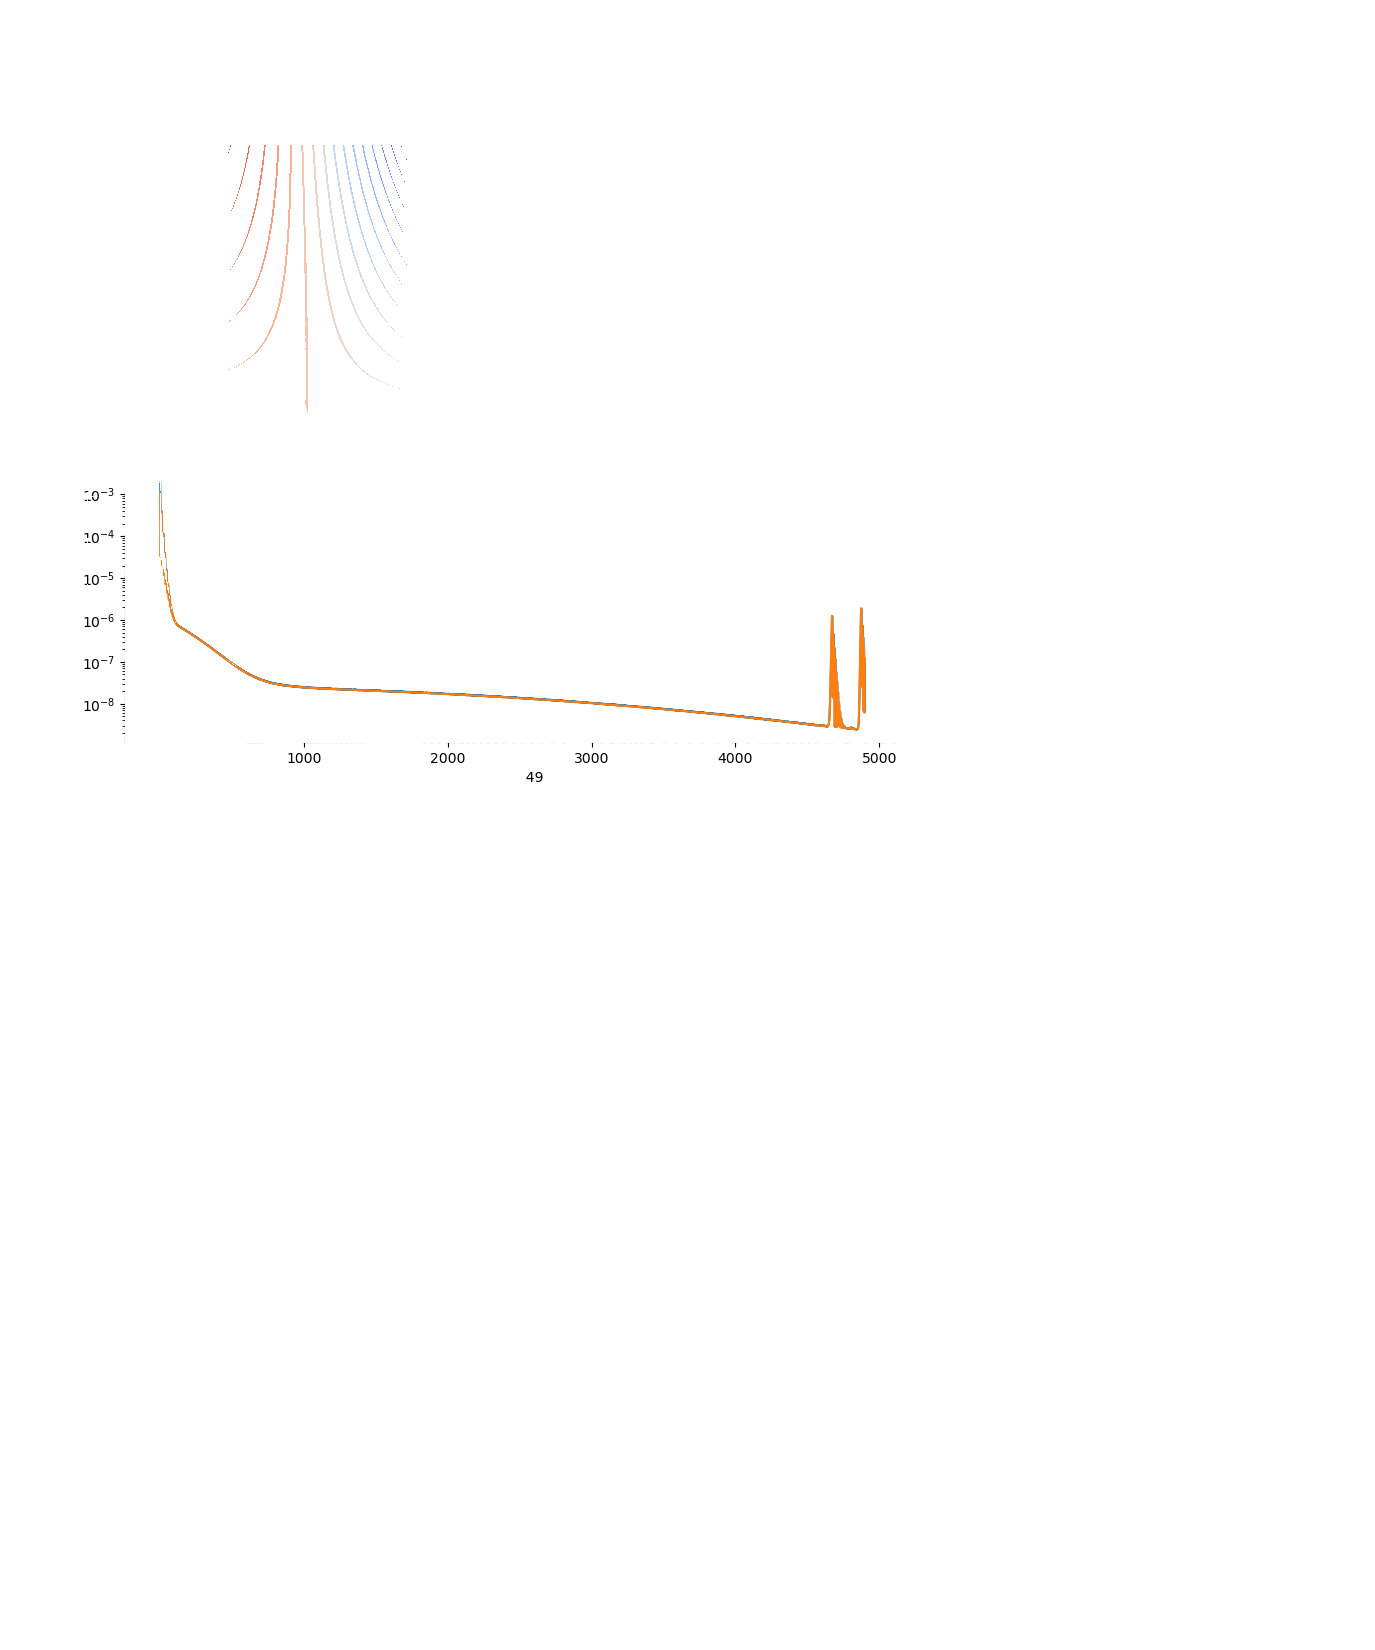

KeyboardInterrupt: 

In [21]:
c , L, T = 0.3, 2, 3
# Define the PDE system
# There's only one (Laplace) equation in the system, so the function maps (u, x, y) to a single entry
wave = lambda u, x, t: [- c * c * diff(u, x, order=2) + diff(u, t, order=2)]

# Define the boundary conditions
# There's only one function to be solved for, so we only have a single condition
conditions = [
    BC2IV2(
        x_min=0, x_min_val=lambda t: torch.sin(c*t),
        x_max=L, x_max_val=lambda t:  torch.sin(c*t) * np.cos(L),
        t_min=0, t_min_val=lambda x:  0,
        t_min_prime=lambda x: c * torch.cos(x)
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=(32,32))
]

# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(L, T))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver = Solver2D(
    pde_system=wave,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(L, T),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_laplace = solver.get_solution()